In [ ]:
import kagglehub

path = kagglehub.dataset_download("debarshichanda/goemotions")
path += "/data"

In [ ]:
import os
import pandas as pd
import json

dataset_dir = path

In [ ]:
import os
import pandas as pd


train_df = pd.read_csv(os.path.join(dataset_dir, "train.tsv"), sep="\t", header=None)
dev_df = pd.read_csv(os.path.join(dataset_dir, "dev.tsv"), sep="\t", header=None)
test_df = pd.read_csv(os.path.join(dataset_dir, "test.tsv"), sep="\t", header=None)


train_df.columns = ["text", "labels", "id"]
dev_df.columns = ["text", "labels", "id"]
test_df.columns = ["text", "labels", "id"]

# Verifying the column names
print("Train DataFrame Columns:", train_df.columns)
print(train_df.head())

In [ ]:
import numpy as np

# Emotions list
with open(os.path.join(dataset_dir, "emotions.txt"), "r") as file:
    emotions = file.read().splitlines()

num_emotions = len(emotions)

def encode_labels(label_str):
    # Converting a comma-separated string of label indices into a multi-hot vector
    label_indices = [int(x.strip()) for x in label_str.split(',')]
    multi_hot = np.zeros(num_emotions, dtype=np.float32)
    for idx in label_indices:
        multi_hot[idx] = 1.0
    return multi_hot

# Applying the encoding function to the 'labels' column for each df
train_df['labels'] = train_df['labels'].apply(encode_labels)
dev_df['labels'] = dev_df['labels'].apply(encode_labels)
test_df['labels'] = test_df['labels'].apply(encode_labels)


print("Encoded training labels:")
print(train_df['labels'].head())

print("Training data shape: ")
print(train_df.shape)

print("dev data shape: ")
print(dev_df.shape)

print("test data shape: ")
print(test_df.shape)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
from transformers import AutoTokenizer
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR


class DistilBertCNN(nn.Module):
    def __init__(self, num_labels):
        super(DistilBertCNN, self).__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        # CNN expects (batch, channels, sequence_length)
        # kernel_size: 5 and padding: 2 to keep the sequence length
        self.conv = nn.Conv1d(in_channels=self.bert.config.dim, out_channels=128, kernel_size=5, padding=2)
        self.dropout = nn.Dropout(0.42)
        self.fc = nn.Linear(128, num_labels)

    def forward(self, input_ids, attention_mask):
        # Get contextual embeddings from DistilBERT
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = bert_output.last_hidden_state  # (batch, seq_len, hidden_dim)
        x = x.transpose(1, 2)              # (batch, hidden_dim, seq_len) for CNN
        x = F.relu(self.conv(x))
        # Global max pooling over sequence length
        x = F.max_pool1d(x, kernel_size=x.size(2)).squeeze(2)
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

In [ ]:
class TweetDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.texts = dataframe.iloc[:, 0].tolist()  # first column for text
        self.labels = dataframe.iloc[:, 1].tolist()   # second column for labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )
        # Removing the extra batch dimension
        item = {key: val.squeeze(0) for key, val in encoding.items()}

        # Converting the already encoded multi-hot label (a numpy array) to a torch tensor
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float32)
        return item

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_dataset = TweetDataset(train_df, tokenizer, max_length=128)
test_dataset  = TweetDataset(test_df, tokenizer, max_length=128)
dev_dataset   = TweetDataset(dev_df, tokenizer, max_length=128)

# DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)
dev_loader   = DataLoader(dev_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = len(emotions)
model = DistilBertCNN(num_labels=num_labels)
model.to(device)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

num_epochs = 5

# Initializing model, optimizer, loss function, and scheduler
model = DistilBertCNN(num_labels=num_labels)
model.to(device)

optimizer = AdamW(model.parameters(), lr=7e-5)
criterion = nn.BCEWithLogitsLoss()  # Using BCEWithLogitsLoss for multi-label classification

# Schedule with a cosine curve
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

for name, param in model.bert.named_parameters():
    if "layer.5" in name or "layer.4" in name or "layer.3" in name:
        param.requires_grad = True  # Fine-tuning only the last 3 layers
    else:
        param.requires_grad = False

for epoch in range(num_epochs):
    # ------------------
    # Training Phase
    # ------------------
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # Making sure that the labels are multi-hot vectors of type float32
        labels = batch['labels'].to(device).float()

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs} - Average Training Loss: {avg_loss:.4f}")

    # ------------------
    # Evaluation Phase
    # ------------------
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []  # To store probabilities for AUC calculation

    with torch.no_grad():
        for batch in dev_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).float()

            logits = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.51).int()

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    # Concatenating arrays from all batches
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    all_probs = np.concatenate(all_probs, axis=0)


    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    try:
        auc = roc_auc_score(all_labels, all_probs, average='macro')
    except ValueError:
        auc = float('nan')  # In case AUC can't be computed (e.g., missing classes)

    print(f"Epoch {epoch+1} Evaluation Metrics:")
    print(f"  F1 Score   : {f1:.4f}")
    print(f"  Precision  : {precision:.4f}")
    print(f"  Recall     : {recall:.4f}")
    print(f"  AUC        : {auc:.4f}")

Evaluation Metrics:
F1 Score: 0.4576
Precision: 0.6113
Recall: 0.3933
AUC: 0.6908
MCC: 0.5676


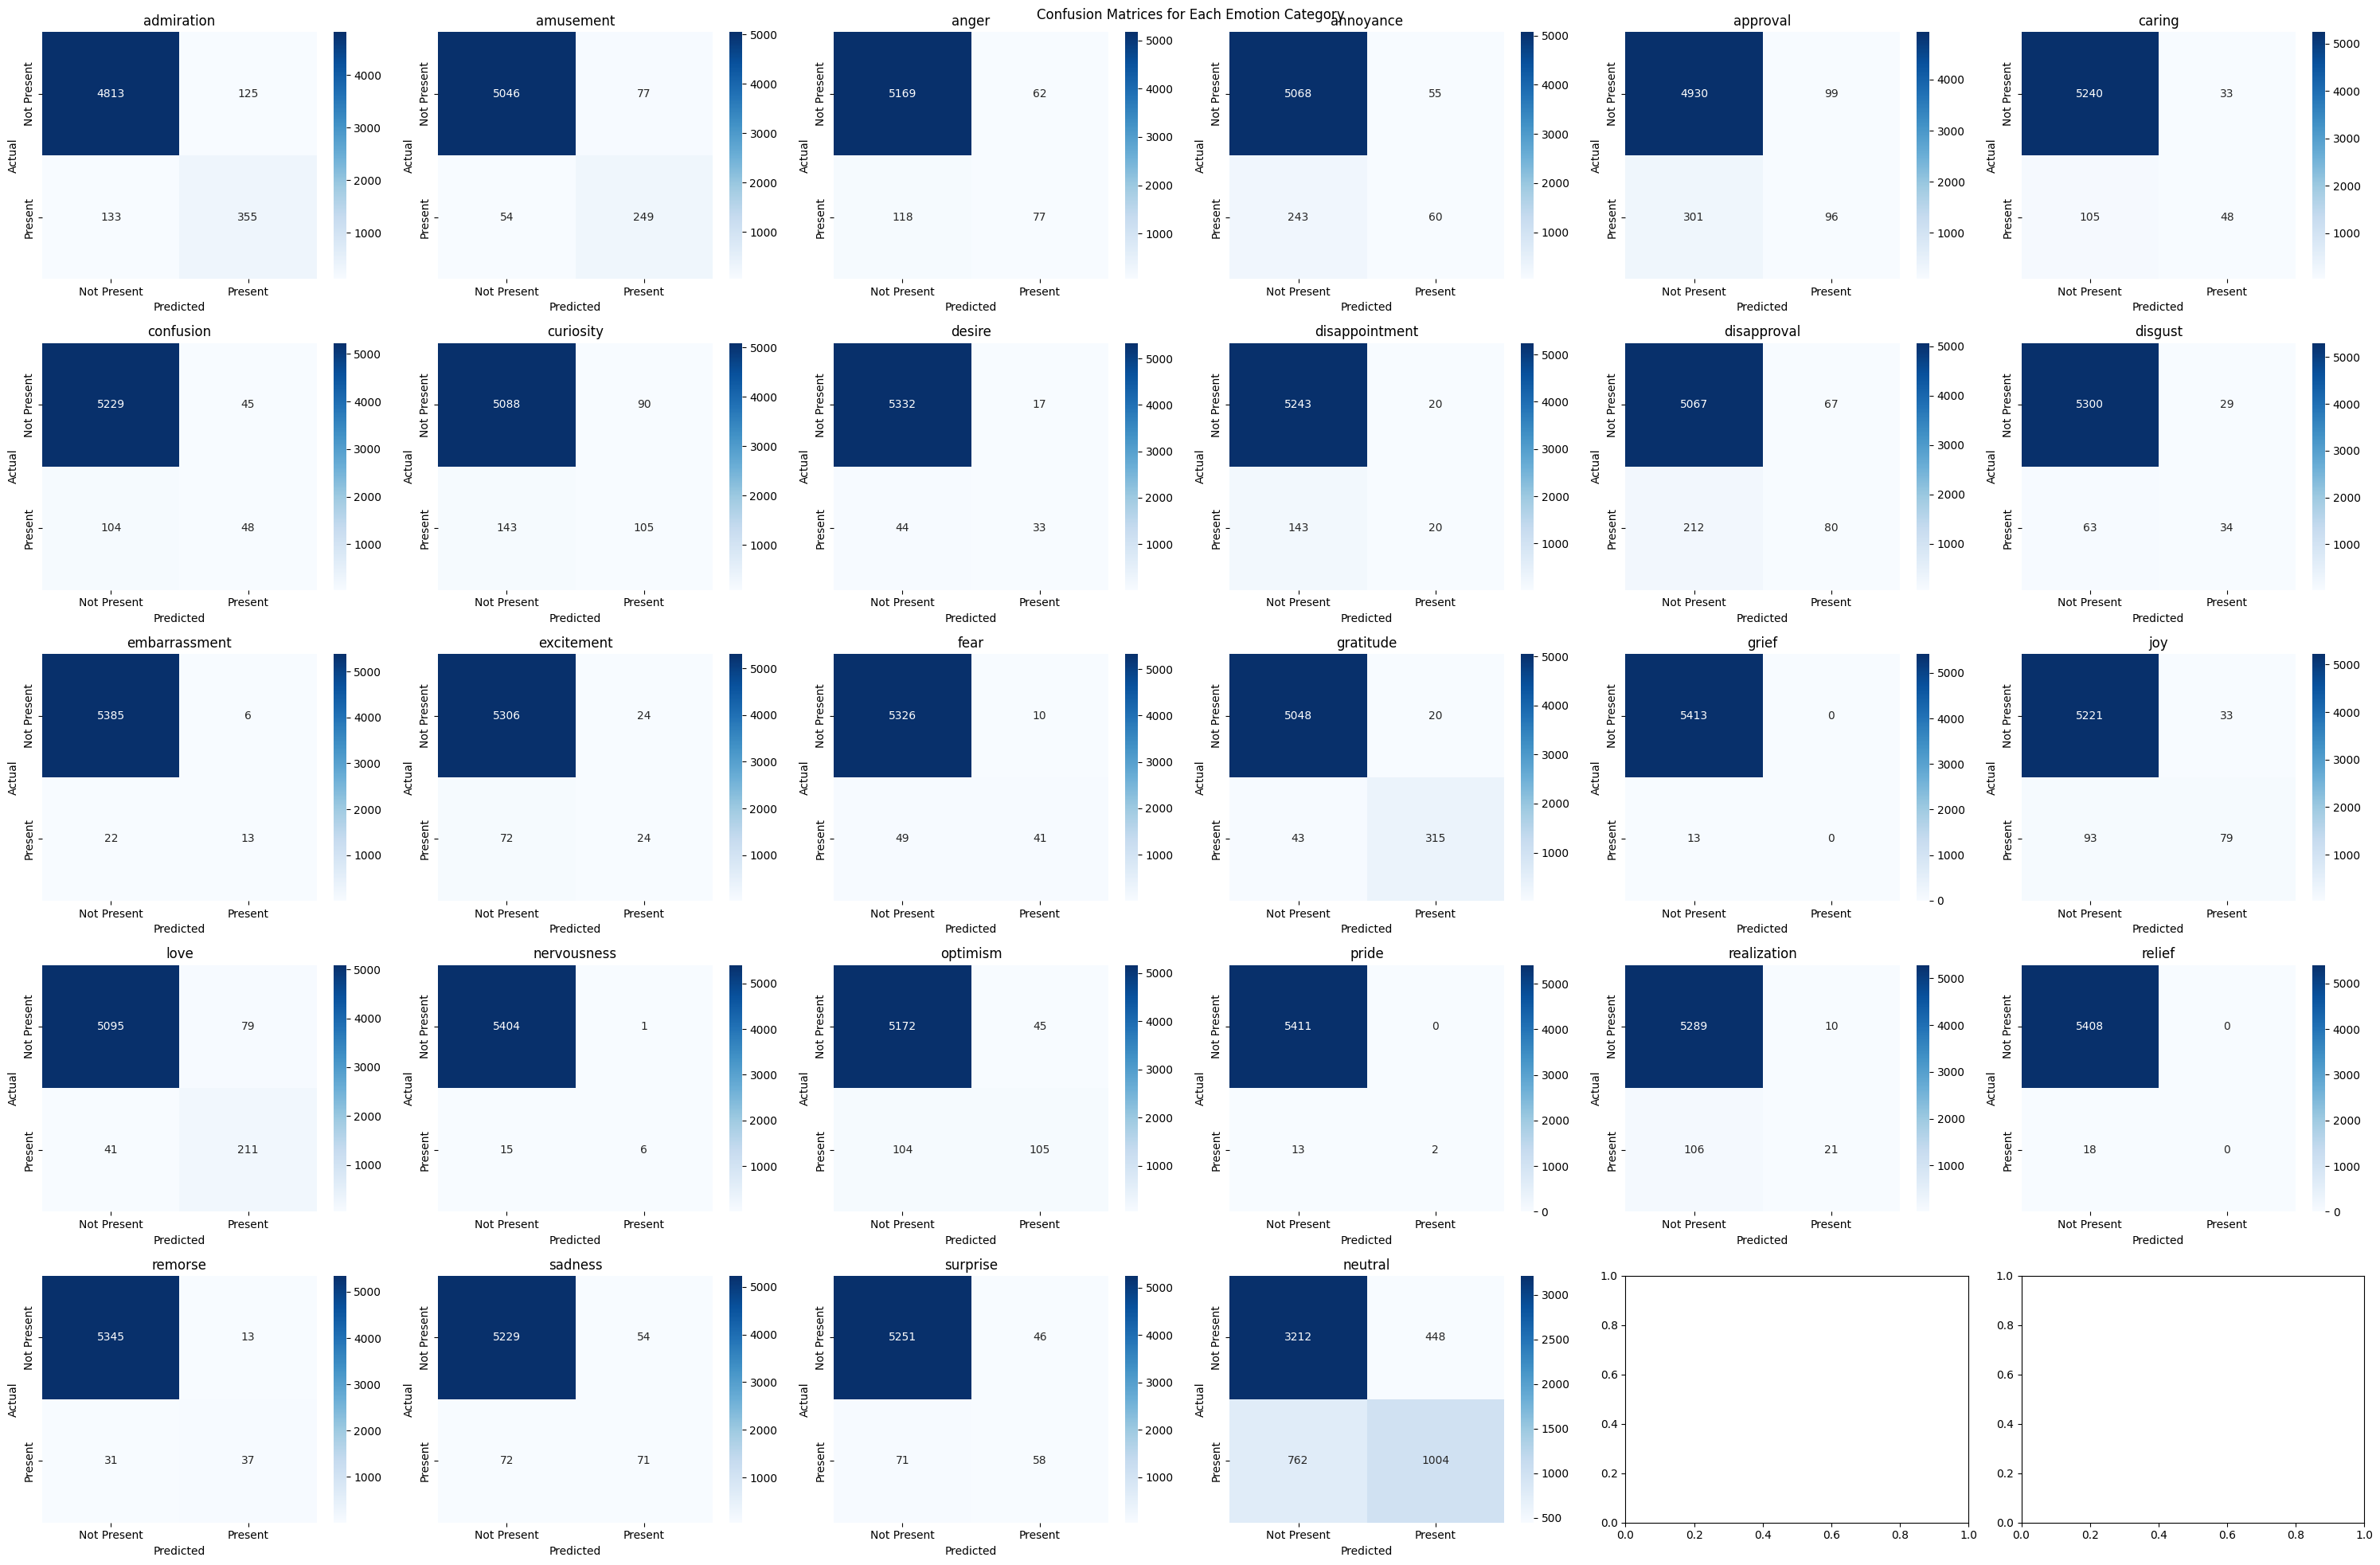

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score,
    matthews_corrcoef, multilabel_confusion_matrix
)

def compute_metrics(predictions, true_labels):
    """
    Computin various evaluation metrics.

    - Predictions: raw logits from the model
    - True labels: ground truth labels in multi-hot encoding format
    """
    # Applying sigmoid to logits and convert to binary predictions using threshold 0.48
    probs = torch.sigmoid(torch.tensor(predictions)).cpu().numpy()
    y_pred = (probs > 0.51).astype(int)  # Convert probabilities to binary labels
    y_true = true_labels.cpu().numpy()  # Ensure labels are on CPU

    # Compute F1, Precision, Recall (macro-average)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

    # Compute AUC Score
    try:
        auc = roc_auc_score(y_true, probs, average='macro')
    except ValueError:
        auc = float('nan')  # Handle cases where AUC can't be computed

    # Compute Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_true.flatten(), y_pred.flatten())

    return {
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall,
        'AUC': auc,
        'MCC': mcc
    }

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Generate a confusion matrix for multi-label classification.
    """
    conf_matrix = multilabel_confusion_matrix(y_true, y_pred)

    fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(30, 20))  # Adjust grid layout if needed
    fig.suptitle("Confusion Matrices for Each Emotion Category")

    for i, ax in enumerate(axes.flatten()):
        if i < len(class_names):  # Ensure we don't access indices beyond class count
            sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap="Blues", xticklabels=['Not Present', 'Present'],
                        yticklabels=['Not Present', 'Present'], ax=ax)
            ax.set_title(class_names[i])
            ax.set_xlabel("Predicted")
            ax.set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

# ---- Evaluation Phase ----
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in dev_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).float()

        logits = model(input_ids, attention_mask)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.51).int()

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
all_probs = np.concatenate(all_probs, axis=0)

# Compute Metrics
metrics = compute_metrics(all_preds, torch.tensor(all_labels))
print("Evaluation Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

# Plot Confusion Matrices
plot_confusion_matrix(all_labels, all_preds, emotions)


In [ ]:
# -------------------------------
# Using the Model


query = "What is going on? I'm so confused."

encoded_q = tokenizer(query, return_tensors="pt", padding=True, truncation=True, max_length=128)

# Move tokenized inputs to the same device as your model
encoded_q = {key: value.to(device) for key, value in encoded_q.items()}

output_q = model(encoded_q["input_ids"], encoded_q["attention_mask"])
prob_dist = F.softmax(output_q, dim=1)


# Remove the batch dimension and get a 1D tensor of probabilities
probabilities = prob_dist[0]

# 5 highest confidence scores and their indices
top_values, top_indices = torch.topk(probabilities, k=5)

print(query, '\n')

for idx, value in zip(top_indices, top_values):
    emotion = emotions[idx.item()]
    confidence = value.item() * 100
    print(f"{emotion}: {confidence:.2f}%")

My dolls have been put away like dead
children in a chest I will carry
with me when I marry.
I reach under my skirt to feel
a satin slip bought for this day. It is soft
as the inside of my thighs. My hair
has been nailed back with my mother’s
black hairpins to my skull. 

neutral: 90.39%
sadness: 3.25%
realization: 0.66%
disgust: 0.65%
approval: 0.56%


In [ ]:
# Saving the model's state dictionary to a file
torch.save(model.state_dict(), "GoEmotionsDistilBertCNN.pth")

tokenizer.save_pretrained("distil_bert_tokenizer_dir")

('distil_bert_tokenizer_dir/tokenizer_config.json',
 'distil_bert_tokenizer_dir/special_tokens_map.json',
 'distil_bert_tokenizer_dir/vocab.txt',
 'distil_bert_tokenizer_dir/added_tokens.json',
 'distil_bert_tokenizer_dir/tokenizer.json')

In [ ]:
# Reinitialize the model architecture (must be the same as when you saved it)
model = DistilBertCNN(num_labels=len(emotions))  # Replace NUM_LABELS with your value

# Load the state dictionary
model.load_state_dict(torch.load("GoEmotionsDistilBertCNN.pth", map_location=device))
model.to(device)  # Move the model to the appropriate device

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distil_bert_tokenizer_dir")
